In [1]:
import os
import sys
sys.path.append(os.pardir) 

In [4]:
from common.util import im2col

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [12]:
import numpy as np

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [14]:
class Convolution:
    def __init__(self, w, b, stride=1, pad=0):
        self.w = w
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.w.shape
        F, N, C, H = x.shape
        out_h = int(1 + (H + 2*self.pad - FH / self.stride))
        out_w = int(1 + (w + 2*self.pad - FW / self.stride))
        
        col = im2col(x, FH, self.stride. self.pad)
        col_w = self.w.reshape(FN, -1).T
        out = np.dot(col, col_w) + self.b
        
        out = out.reshape(N, out_h, -1).transpose(0, 3, 1, 2)
        
        return out


In [15]:
class Poling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1+ (H - self.pool_h / self.stride))
        out_w = int(1+ (W - self.pool_w / self.stride))
        
        col = self.im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
    

train loss:2.300219990406198
=== epoch:1, train acc:0.245, test acc:0.252 ===
train loss:2.298444386740061
train loss:2.2927431198536983
train loss:2.2886852720421604
train loss:2.2841944472600546
train loss:2.2664479198349348
train loss:2.2565745266448567
train loss:2.2426637265371054
train loss:2.2197834970467785
train loss:2.2049620936856016
train loss:2.1587653498956976
train loss:2.1230331643480924
train loss:2.084391134975676
train loss:2.070484811778383
train loss:2.002105135402647
train loss:1.9695139221246207
train loss:1.8555097799854812
train loss:1.8070829583334096
train loss:1.7445743642620917
train loss:1.629399347175732
train loss:1.6182901222866428
train loss:1.5897104652421905
train loss:1.4291033214180948
train loss:1.330020313307263
train loss:1.3590257743893168
train loss:1.2316762235941061
train loss:1.116099462082707
train loss:1.0965438508869472
train loss:1.1744678464603426
train loss:0.9070094340701667
train loss:0.8966035879989667
train loss:0.8470175475464788

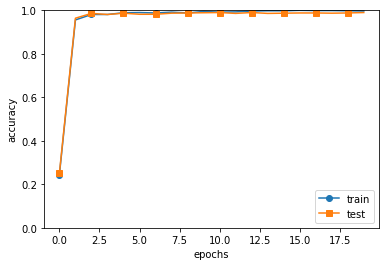

In [17]:
# https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/train_convnet.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_pa ram = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

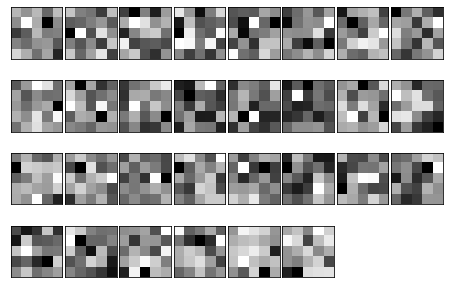

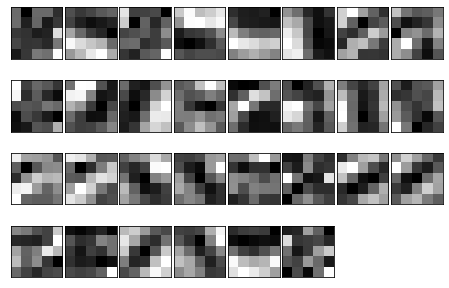

In [18]:
# https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/visualize_filter.py

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])